## Busca dos logs no Elastic

In [5]:
from elasticsearch import Elasticsearch
import pandas as pd
from datetime import timedelta

es = Elasticsearch(
    "http://192.168.56.102:9200",
    basic_auth=("elastic", "123456")
)

atomicData = pd.read_csv('data/labels/logs_malicious.csv').drop('IP Address', axis=1)

# Conversão de Series para timestamp e adição do tempo final
atomicData['Execution Time (UTC)'] = pd.to_datetime(atomicData['Execution Time (UTC)'], format="%Y-%m-%dT%H:%M:%SZ")
for i in range(1, len(atomicData)):
    if i == len(atomicData) - 1:
        atomicData.loc[i, 'Execution Time End (UTC)'] = atomicData.loc[i, 'Execution Time (UTC)'] + timedelta(seconds=20)
    atomicData.loc[i - 1, 'Execution Time End (UTC)'] = atomicData.loc[i, 'Execution Time (UTC)'] - timedelta(seconds=1)

atomicData = atomicData.drop(['Execution Time (Local)', 'Username', 'GUID', 'ExitCode'], axis=1)
display(atomicData)

for index, row in atomicData.iterrows():
    query = {
        "size": 500,
        "_source": [
            "process.name",
            "process.command_line",
            "file.path",
            "winlog.task"
        ],
        "query": {
            "bool": {
                "must": [
                    {
                        "range": {
                            "@timestamp": {
                                "gte": row['Execution Time (UTC)'],
                                "lte": row['Execution Time End (UTC)']
                            }
                        }
                    }
                ]
            }
        }
    }

    response = es.search(index="winlogbeat-*", body=query)
    events = [hit["_source"] for hit in response["hits"]["hits"]]
    
    # Salvando dados de eventos em data/events/{timestamp}.csv
    pd_events = pd.DataFrame(events)
    pd_events.to_json(f'data/events/{row['Execution Time (UTC)'].strftime("%Y%m%d_%H%M%S")}.jsonl', orient="records", lines=True, force_ascii=False)

,Execution Time (UTC),Technique,Test Number,Test Name,Hostname,ProcessId,Execution Time End (UTC)
0,2025-04-11 17:57:49,T1053.005,2,Scheduled task Local,DESKTOP-VPIQCN1,12056,2025-04-11 17:58:05
1,2025-04-11 17:58:06,T1547.001,1,Reg Key Run,DESKTOP-VPIQCN1,11328,2025-04-11 17:58:25
2,2025-04-11 17:58:26,T1070.006,6,Windows - Modify file last modified timestamp ...,DESKTOP-VPIQCN1,9388,2025-04-11 17:58:54
3,2025-04-11 17:58:55,T1552.004,1,Private Keys,DESKTOP-VPIQCN1,1072,2025-04-11 17:59:58
4,2025-04-11 17:59:59,T1087.001,9,Enumerate all accounts via PowerShell (Local),DESKTOP-VPIQCN1,1196,2025-04-11 18:00:54
5,2025-04-11 18:00:55,T1074.001,3,Zip a Folder with PowerShell for Staging in Temp,DESKTOP-VPIQCN1,11592,2025-04-11 18:01:20
6,2025-04-11 18:01:21,T1105,10,Windows - PowerShell Download,DESKTOP-VPIQCN1,12240,2025-04-11 18:02:01
7,2025-04-11 18:02:02,T1047,5,WMI Execute Local Process,DESKTOP-VPIQCN1,11480,2025-04-11 18:02:12
8,2025-04-11 18:02:13,T1546.008,2,Replace binary of sticky keys,DESKTOP-VPIQCN1,5596,2025-04-11 18:02:23
9,2025-04-11 18:02:24,T1036.004,1,Creating W32Time similar named service using s...,DESKTOP-VPIQCN1,1524,2025-04-11 18:02:36


## Ofuscação dos logs

In [13]:
import pandas as pd
import glob
import re
import random

users = [
    'admin', 'root', 'guest', 'art-test', 'test', 'default',
    'administrator', 'superuser', 'sysadmin'
]
tools = [
    'redcanaryco', re.compile(r'[aA]tomic[\w -]*'), 'mimikatz', 'nmap', 'cobaltstrike', 'metasploit', 'ExternalPayloads', re.compile('_timestomp'), re.compile(r'r\d{3,}'), 'Folder_to_zip'
]
passwords = [
    re.compile(r'Password123\!'), '123456', 'admin123', 'qwerty', 'letmein',
    'passw0rd', '12345678', 'toor', re.compile(r'-4RTisCool!-321')
]
mitre = [re.compile(r"T\d{4}\.\d{3}"), re.compile(r"T\d{4}")]

ofuscation = users + tools + passwords + mitre

prefixos = [
    "modulo", "componente", "estrutura", "registro", "entrada", "elemento", "tarefa", "pacote", "unidade", "objeto"
]

sufixos = [
    "base", "padrao", "logico", "comum", "principal", "secundario", "auxiliar", "temporario", "ativo", "geral"
]
def random_words(text):
    text = str(text)
    
    return f"{random.choice(prefixos)}_{random.choice(sufixos)}"

def apply_obfuscation(text, terms):
    text = str(text)

    for term in terms:
        if isinstance(term, re.Pattern):
            # Aplica a substituição para o padrão regex
            text = term.sub(lambda m: random_words(m.group()), text).replace('\\\\', '\\')
        else:
            # Cria um padrão com limites de palavra para substituir termos completos
            padrao = r'\b' + re.escape(term) + r'\b'
            text = re.sub(padrao, lambda m: random_words(m.group()), text)
    return text

jsonl_files = glob.glob("data/events/*.jsonl")
for file in jsonl_files:
    df = pd.read_json(file, lines=True)
    
    for column in df.columns:
        df[column] = df[column].apply(lambda x: apply_obfuscation(x, ofuscation))

    new_file = file.replace("events", "events_processed")
    df.to_json(new_file, orient="records", lines=True, force_ascii=False)

## Escolha de Logs relevantes

In [ ]:
import ollama
import os
import glob
import pandas as pd

JSONL_DIR = "data/events_processed"
MODEL = "llama3.2:3b"
MODEL_PATH = "llama3.2_3b"

jsonl_files = glob.glob(f"{JSONL_DIR}/*.jsonl")

for file in jsonl_files:
    alerts = pd.read_json(file, orient='records', lines=True)
    results = []
    for _, row in alerts.iterrows():
        alert = row.to_dict()
        response = ollama.chat(
            model=MODEL,
            messages=[
                {
                    "role": "system",
                    "content": (
                        "You are a cybersecurity expert. Please review each log individually and return ONLY the classification as 'IMPORTANT' or 'NOT IMPORTANT'. "
                        "Sensitive data is obfuscated."
                    )
                },
                {
                    "role": "user",
                    "content": f"Here are the logs:\n{alert}"
                }
            ],
            options={"max_tokens": 60}
        )

        analysis = response['message']['content'].strip()
        if not "NOT IMPORTANT" in analysis:
            results.append(alert)

    # Salvando os resultados
    dir_path = f"data/events_filtered/{MODEL_PATH}"
    os.makedirs(dir_path, exist_ok=True)

    filename = os.path.basename(file)  # Mantém o nome do arquivo original
    output_path = os.path.join(dir_path, filename)

    pd.DataFrame(results).to_json(output_path, orient="records", lines=True, force_ascii=False)
    print(f"Inferência salva em {output_path}")


Inferência salva em data/events_filtered/llama3.2_3b\20250411_175749.jsonl
Inferência salva em data/events_filtered/llama3.2_3b\20250411_175806.jsonl
Inferência salva em data/events_filtered/llama3.2_3b\20250411_175826.jsonl
Inferência salva em data/events_filtered/llama3.2_3b\20250411_175855.jsonl
Inferência salva em data/events_filtered/llama3.2_3b\20250411_175959.jsonl
Inferência salva em data/events_filtered/llama3.2_3b\20250411_180055.jsonl
Inferência salva em data/events_filtered/llama3.2_3b\20250411_180121.jsonl
Inferência salva em data/events_filtered/llama3.2_3b\20250411_180202.jsonl
Inferência salva em data/events_filtered/llama3.2_3b\20250411_180213.jsonl
Inferência salva em data/events_filtered/llama3.2_3b\20250411_180224.jsonl
Inferência salva em data/events_filtered/llama3.2_3b\20250411_180237.jsonl
Inferência salva em data/events_filtered/llama3.2_3b\20250411_180254.jsonl
Inferência salva em data/events_filtered/llama3.2_3b\20250411_180316.jsonl
Inferência salva em data/

## Comparar redução de logs

In [ ]:
import os

processed_path = "data/events_processed"
filtered_path = "data/events_filtered/llama3.2_3b"
processed_total = 0
filtered_total = 0

for filename in os.listdir(processed_path):
    processed_file = os.path.join(processed_path, filename)
    filtered_file = os.path.join(filtered_path, filename)

    if os.path.exists(filtered_file):
        with open(processed_file, 'r', encoding='utf-8') as f1:
            lines_processed = sum(1 for _ in f1)

        with open(filtered_file, 'r', encoding='utf-8') as f2:
            lines_filtered = sum(1 for _ in f2)
        
        processed_total = processed_total + lines_processed
        filtered_total = filtered_total + lines_filtered
        print(f"{filename}: {lines_processed} -> {lines_filtered}")
    else:
        print(f"{filename}: arquivo correspondente não encontrado em events_filtered.")

print(f"{processed_total} -> {filtered_total}")

20250411_175749.jsonl: 85 -> 48
20250411_175806.jsonl: 16 -> 10
20250411_175826.jsonl: 69 -> 40
20250411_175855.jsonl: 53 -> 33
20250411_175959.jsonl: 80 -> 55
20250411_180055.jsonl: 62 -> 43
20250411_180121.jsonl: 247 -> 138
20250411_180202.jsonl: 20 -> 12
20250411_180213.jsonl: 45 -> 28
20250411_180224.jsonl: 29 -> 16
20250411_180237.jsonl: 20 -> 11
20250411_180254.jsonl: 51 -> 29
20250411_180316.jsonl: 347 -> 209
20250411_180502.jsonl: 65 -> 40
20250411_180536.jsonl: 43 -> 25
20250411_180602.jsonl: 42 -> 21
20250411_180623.jsonl: 31 -> 18
20250411_180641.jsonl: 50 -> 24
20250411_180654.jsonl: 45 -> 30
20250411_180711.jsonl: 249 -> 147
20250411_180823.jsonl: 60 -> 32
20250411_180856.jsonl: 37 -> 23
20250411_180927.jsonl: 51 -> 35
20250411_180952.jsonl: 28 -> 19
20250411_181019.jsonl: 43 -> 27
20250411_181050.jsonl: 40 -> 21
20250411_181122.jsonl: 221 -> 138
20250411_181227.jsonl: 81 -> 56
20250411_181243.jsonl: 67 -> 45
20250411_181301.jsonl: 38 -> 23
20250411_181320.jsonl: 67 -> 36


## Inferência

In [ ]:
import openai
import time
import glob
import os
import pandas as pd
from dotenv import load_dotenv

CSV_DIR = "src/filtering/llama3.2_3b/scenario1"
load_dotenv()
results = []
OPENAI_API_KEY = os.getenv('OPENAI_KEY')

client = openai.OpenAI(api_key=OPENAI_API_KEY)

# for i in range(1, 6):
#     results = []
#     csv_files = glob.glob(f"{CSV_DIR}/scenarios/scenario_{i}/*.jsonl")

#     with open(f"{CSV_DIR}/scenarios/scenario_{i}.jsonl", "w", encoding="utf-8") as outfile:
#         for file in csv_files:
#             with open(file, "r", encoding="utf-8") as infile:
#                 for line in infile:
#                     outfile.write(line)

for file in glob.glob(f"{CSV_DIR}/*.jsonl"):
    alert = pd.read_json(file, orient='records', lines=True)
    response = client.chat.completions.create(
    model="gpt-4o-mini",
    messages = [
            {
                "role": "system",
                "content": (
                    "Você é um especialista em cibersegurança com vasta experiência em analisar logs de sistema para "
                    "identificar comportamentos maliciosos. Sua tarefa é analisar o conjunto completo de eventos de log apresentado "
                    "e classificar como 'Interessante' ou 'Não interessante'. NÃO UTILIZE o uso excessivo de PowerShell como justificativa"
                )
            },
            {
                "role": "system",
                "content": (
                    "Retorne SOMENTE a {CLASSIFICAÇÃO:{'INTERESSANTE'|'NÃO INTERESSANTE'}, JUSTIFICATIVA:{justificativa}}."
                )
            },
            {
                "role": "user",
                "content": f"Aqui estão os logs (todos os dados sensíveis foram ofuscados):\n{alert.to_json(orient='records', lines=True)}."
            }
        ],
    )
    
    analysis = response.choices[0].message.content
    results.append({"file": file, "analysis": analysis})
    time.sleep(0.5)

    results_df = pd.DataFrame(results)

    dir_path = "src/inference/gpt-4o-mini"
    os.makedirs(dir_path, exist_ok=True)
    results_df.to_csv(f"{dir_path}/inference.csv", index=False)
    

NameError: name 'results' is not defined

## Gráficos

Scenario 1: Total linhas = 7, 'INTERESSANTE' = 7, Acurácia = 100.00%
Scenario 2: Total linhas = 6, 'INTERESSANTE' = 3, Acurácia = 50.00%
Scenario 3: Total linhas = 7, 'INTERESSANTE' = 6, Acurácia = 85.71%
Scenario 4: Total linhas = 7, 'INTERESSANTE' = 7, Acurácia = 100.00%
Scenario 5: Total linhas = 5, 'INTERESSANTE' = 5, Acurácia = 100.00%


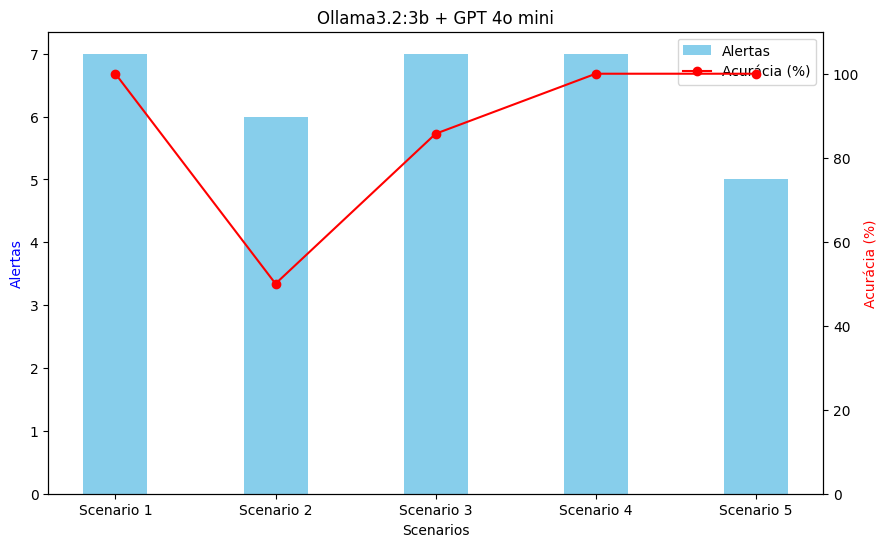

In [43]:
import os
import pandas as pd
import matplotlib.pyplot as plt

dir_path = 'graphics/random'
scenarios = [1, 2, 3, 4, 5]

counts = []
accuracy_values = []
total_lines = []
for s in scenarios:
    
    file_path = os.path.join(dir_path, f'scenario_{s}.csv')

    df = pd.read_csv(file_path)

    total = len(df)
    
    # Conta quantas linhas têm "NÃO INTERESSANTE" pelo menos uma vez na coluna 'classification'
    # É usada a conversão para string para evitar problemas com valores NaN
    count = df['classification'].apply(lambda x: "NÃO INTERESSANTE" not in str(x)).sum()
    
    # Calcula a acurácia (por exemplo, a porcentagem de linhas com a ocorrência)
    accuracy = (count / total) * 100 if total > 0 else 0
    
    counts.append(total)
    accuracy_values.append(accuracy)
    
    # Exibe os dados do cenário
    print(f"Scenario {s}: Total linhas = {total}, 'INTERESSANTE' = {count}, Acurácia = {accuracy:.2f}%")

# Cria o gráfico
fig, ax1 = plt.subplots(figsize=(10, 6))

# Define a largura das barras
bar_width = 0.4
index = range(len(scenarios))

# Plota as barras para a contagem de ocorrências
bars = ax1.bar(index, counts, bar_width, label="Alertas", color='skyblue')
ax1.set_xlabel('Scenarios')
ax1.set_ylabel("Alertas", color='blue')
ax1.set_xticks(index)
ax1.set_xticklabels([f"Scenario {s}" for s in scenarios])

# Cria um segundo eixo y para a acurácia
ax2 = ax1.twinx()
ax2.plot(index, accuracy_values, color='red', marker='o', label="Acurácia (%)")
ax2.set_ylabel('Acurácia (%)', color='red')
ax2.set_ylim(0, 110)

# Junta as legendas dos dois gráficos
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc="upper right")

# Título e layout
plt.title("Ollama3.2:3b + GPT 4o mini")
# Exibe o gráfico
plt.savefig("graphics/random/acurácia")
plt.show()


Scenario 1: Total linhas = 7, 'INTERESSANTE' = 7, Acurácia = 100.00%
Scenario 2: Total linhas = 6, 'INTERESSANTE' = 5, Acurácia = 83.33%
Scenario 3: Total linhas = 7, 'INTERESSANTE' = 7, Acurácia = 100.00%
Scenario 4: Total linhas = 7, 'INTERESSANTE' = 7, Acurácia = 100.00%
Scenario 5: Total linhas = 5, 'INTERESSANTE' = 5, Acurácia = 100.00%


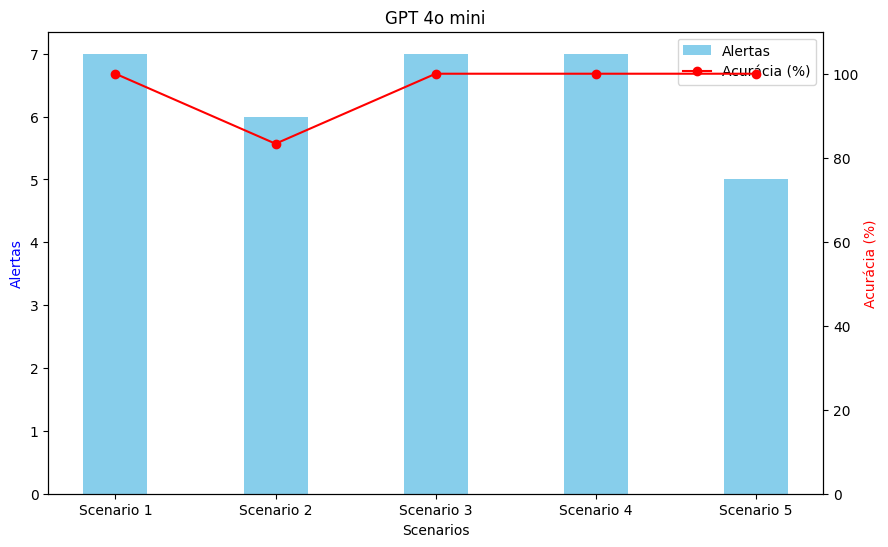

In [42]:
import os
import pandas as pd
import matplotlib.pyplot as plt

dir_path = 'graphics/normal'
scenarios = [1, 2, 3, 4, 5]

counts = []
accuracy_values = []

for s in scenarios:
    file_path = os.path.join(dir_path, f'scenario_{s}.csv')

    df = pd.read_csv(file_path)
    total = len(df)
    
    # Conta quantas linhas têm "NÃO INTERESSANTE" pelo menos uma vez na coluna 'classification'
    # É usada a conversão para string para evitar problemas com valores NaN
    count = df['classification'].apply(lambda x: "NÃO INTERESSANTE" not in str(x)).sum()
    
    # Calcula a acurácia (por exemplo, a porcentagem de linhas com a ocorrência)
    accuracy = (count / total) * 100 if total > 0 else 0
    
    counts.append(total)
    accuracy_values.append(accuracy)
    
    # Exibe os dados do cenário
    print(f"Scenario {s}: Total linhas = {total}, 'INTERESSANTE' = {count}, Acurácia = {accuracy:.2f}%")

# Cria o gráfico
fig, ax1 = plt.subplots(figsize=(10, 6))

# Define a largura das barras
bar_width = 0.4
index = range(len(scenarios))

# Plota as barras para a contagem de ocorrências
bars = ax1.bar(index, counts, bar_width, label="Alertas", color='skyblue')
ax1.set_xlabel('Scenarios')
ax1.set_ylabel("Alertas", color='blue')
ax1.set_xticks(index)
ax1.set_xticklabels([f"Scenario {s}" for s in scenarios])

# Cria um segundo eixo y para a acurácia
ax2 = ax1.twinx()
ax2.plot(index, accuracy_values, color='red', marker='o', label="Acurácia (%)")
ax2.set_ylabel('Acurácia (%)', color='red')
ax2.set_ylim(0, 110)

# Junta as legendas dos dois gráficos
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc="upper right")

# Título e layout
plt.title("GPT 4o mini")
# Exibe o gráfico
plt.savefig("graphics/normal/acurácia")
plt.show()
